# Setup ToyData

In [1]:
class ToyData:

    def __init__(self):

        self.attributes = {'color':['y', 'g', 'b'], 'size':['s','l'], 'shape':['r', 'i']}
        self.classes = ('+', '-')

        self.data = [('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'i'),
                 ('g', 'l', 'i'),
                 ('y', 'l', 'r'),
                 ('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 's', 'i'),
                 ('y', 'l', 'i')]
        self.target = ('+', '-', '+', '-', '+', '+', '+', '+', '-', '-', '+', '-', '-', '-', '+', '+')

        self.testData = [('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'i'),
                 ('g', 'l', 'i'),
                 ('y', 'l', 'r')]

        self.testTarget = ('+', '-', '+', '-', '+')

    def get_data(self):
        return self.attributes, self.classes, self.data, self.target, self.testData, self.testTarget



# Implement decision tree classifier based on the ID3 algorithm

In [2]:
from collections import Counter
from graphviz import Digraph


In [56]:
class ID3DecisionTreeClassifier :
    def __init__(self, minSamplesLeaf = 1, minSamplesSplit = 2) :
        
        self.attr_index = {}
        self.__nodeCounter = 0

        # the graph to visualise the tree
        self.__dot = Digraph(comment='The Decision Tree')

        # suggested attributes of the classifier to handle training parameters
        self.__minSamplesLeaf = minSamplesLeaf
        self.__minSamplesSplit = minSamplesSplit


    # Create a new node in the tree with the suggested attributes for the visualisation.
    # It can later be added to the graph with the respective function
    def new_ID3_node(self):
        node = {'id': self.__nodeCounter, 'label': None, 'attribute': None, 'entropy': None, 'samples': None,
                         'classCounts': None, 'nodes': None}

        self.__nodeCounter += 1
        return node

    # adds the node into the graph for visualisation (creates a dot-node)
    def add_node_to_graph(self, node, parentid=-1):
        nodeString = ''
        for k in node:
            if ((node[k] != None) and (k != 'nodes')):
                nodeString += "\n" + str(k) + ": " + str(node[k])

        self.__dot.node(str(node['id']), label=nodeString)
        if (parentid != -1):
            self.__dot.edge(str(parentid), str(node['id']))

    # make the visualisation available
    def make_dot_data(self) :
        return self.__dot

    # For you to fill in; Suggested function to find the best attribute to split with, given the set of
    # remaining attributes, the currently evaluated data and target.
    def find_split_attr(self, data,target,attributes,classes):
        max_info_gain = None
        for attr in attributes:
            remaining_attr = self.removekey(attributes,attr)
            i_gain, ent = self.info_gain(attr, data,target,attributes,classes)
            if max_info_gain is None or i_gain > max_info_gain:
                max_info_gain = i_gain
                max_info_gain_attr = attr
                
        return max_info_gain_attr, ent
    
    # removes key
    def removekey(self, d, key):
        r = dict(d)
        del r[key]
        return r
    
    def entropy_split(self,data,target,col,val):
        cnt = Counter()
        
        for i in range(len(data)):
            if data[i][col] == val:
                cnt[target[i]] += 1
            
        n_v = len(list(cnt.elements()))
        ent_v = 0
        if n_v > 0:
            for cl in classes:
                p_x = cnt[cl]/n_v
                if p_x != 0:
                    ent_v += -p_x*math.log(p_x,2)
        return ent_v, n_v
    
    def info_gain(self,split, data,target,attributes,classes):
        # Calculate the entropy first
        entropy = 0
        cnt = Counter(target)
        n = len(target)
        
        for cl in classes:
            p_x = cnt[cl]/n
            entropy += - p_x * math.log(p_x,2)
        
        col = self.attr_index[split]
        info_gain = entropy
        for val in attributes[split]:
            ent_v, n_v = self.entropy_split(data,target, col, val)
            info_gain += - n_v/n*ent_v
            
        return info_gain, entropy
            
                
    # Use this function split the data acording to the split attribute
    # Return values are dicts with value of split attribute as keys and the data/targets as items.
    def find_data_split(self,data,target,attributes,classes,split):
        data_split = {}
        target_split = {}
        col = self.attr_index[split]
        for vals in attributes[split]:
            data_split[vals] = []
            target_split[vals] = []
            for i in range(len(target)):
                if data[i][col] == vals:
                    data_split[vals].append(data[i])
                    target_split[vals].append(target[i])
                   
        return data_split, target_split
        

    # the entry point for the recursive ID3-algorithm, you need to fill in the calls to your recursive implementation
    def fit(self, data, target, attributes, classes, parent_id = -1):
        if self.__nodeCounter == 0:
            for attr in attributes:
                self.attr_index[attr] = list(attributes.keys()).index(attr)
                
        node = self.new_ID3_node()
#         self.add_node_to_graph(node)
        cnt = Counter(target)
        node['samples'] = len(target)
        node['classCounts'] = cnt
        if len(cnt) == 1:
            node['label'] = target[0]
            self.add_node_to_graph(node,parent_id)
            return node
        
        elif len(attributes) == 0:
            node['label'] = cnt.most_common(1)[0][0]
            self.add_node_to_graph(node, parent_id)
            return node
        else:
            split,ent = self.find_split_attr(data,target,attributes,classes)
            node['nodes'] = {}
            node['entropy'] = ent
            node['attribute'] = split
            fit_data, fit_target = self.find_data_split(data,target,attributes,classes,split)    
            for vals in attributes[split]:
                if len(fit_target[vals]) == 0:
                    leaf_node = self.new_ID3_node()
                    leaf_node['label'] = cnt.most_common(1)[0][0]
                    leaf_node['samples'] = 0
                    self.add_node_to_graph(leaf_node,int(node['id']))
                    node['nodes'][vals] = leaf_node
                else:
                    remaining_attr = self.removekey(attributes, split)
                    print(attributes)
                    print(split)
                    print(ent)
                    print(remaining_attr)
                    node['nodes'][vals] = self.fit(fit_data[vals],fit_target[vals],remaining_attr,classes, int(node['id']))

        # fill in something more sensible here..  root should become the output of the recursive tree creation
        # root = self.new_ID3_node()
        # self.add_node_to_graph(root)
        self.add_node_to_graph(node, parent_id)
        return node
    

    def predict(self, data, tree) :
        predicted = list()
        
        def traverse(one_data, node):
            if node['label'] is not None:
                return node['label']
            elif node['nodes'] is not None:
                attr = node['attribute']
                val = one_data[self.attr_index[attr]]  
                return traverse(one_data,node['nodes'][val])
                
            
        for i in range(len(data)):
            predicted.append(traverse(data[i],tree))
            

        # fill in something more sensible here... root should become the output of the recursive tree creation
        return predicted

# Run the ID3 classifier

In [57]:
# import ToyData as td
# import ID3

import numpy as np
import math
from sklearn import tree, metrics, datasets


In [ ]:
attributes, classes, data, target, data2, target2 = ToyData().get_data()

id3 = ID3DecisionTreeClassifier()

myTree = id3.fit(data, target, attributes, classes)
print(myTree)
plot = id3.make_dot_data()
plot.render("testTree")
predicted = id3.predict(data2, myTree)
print(predicted)

In [59]:
print(predicted)
print(target2)

['+', '+', '+', '-', '-']
('+', '-', '+', '-', '+')


# ID3 classifier with digits dataset

In [60]:
from sklearn import datasets,metrics
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [61]:
digits = datasets.load_digits()
# digit.data

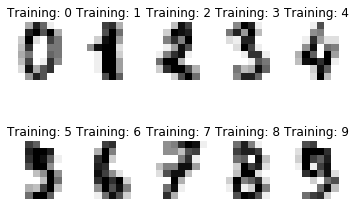

In [62]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [63]:
num_examples = len(digits.data)
num_split = int(0.7*num_examples)
train_features = digits.data[:num_split]
train_labels =  digits.target[:num_split]
test_features = digits.data[num_split:]
test_labels = digits.target[num_split:]

In [68]:
print("Number of training examples: ",len(train_features))
print("Number of test examples: ",len(test_features))
print("Number of total examples:", len(train_features)+len(test_features))
train_labels

Number of training examples:  1257
Number of test examples:  540
Number of total examples: 1797


array([0, 1, 2, ..., 4, 3, 1])

In [ ]:
id3_2 = ID3DecisionTreeClassifier()

classes = [i for i in range(10)]

my2Tree = id3_2.fit(train_features, train_labels, ,classes)

# Accuracy metrics

In [74]:
def getMetrics(TP,FP,TN,FN):
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1-score, support

def metricsReport(target, predictions,classes):
    for cl in classes:
        FP = 0
        TP = 0
        TN = 0
        FN = 0
        for i in range(len(predictions)):
            if target[i] == val[i]:
                if val[i] == cl:
                    TP += 1
                else:
                    FN += 1
            else:
                if val[i] == cl:
                    FP += 1
                else:
                    TN += 1
        pre, re, f1, sup = getMetrics(TP,FP,TN,FN)
        print(cl, "precision",pre)
        print(cl, "recall", re)
        print(cl, "f1-score", f1)
        print(cl, "support", sup)
        
            
                